# scRNA-seq Analysis of *Parhyale hawaiensis* with Scanpy

Author: Miquel Sendra  
This notebook follows best practices for reproducible single-cell RNA-seq analysis using `scanpy`, starting from STARsolo outputs.

In [260]:
# Imports and settings
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import scipy.sparse

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set up paths
DATA_DIR = Path("/home/msendra/workspace/scParhyale_data/raw")
PROC_DATA_DIR = Path("../../../workspace/scParhyale_data/processed")
METADATA_FILE = Path("../../../workspace/scParhyale_data/metadata.xlsx")
LIBRARIES = ["lib01", "lib02", "lib03", "lib04", "lib05", "lib06"]



# Set global figure size and font sizes
sc.set_figure_params(
    dpi=100,
    figsize=(4, 3),         # smaller plots → bigger text
    fontsize=12,            # default font size
    dpi_save=300,
    format='png'
)

## Load Metadata

In [258]:
# Load only relevant columns
metadata_df = pd.read_excel(METADATA_FILE, usecols=["Count", "Sample Name"])

# Exctract Stage and Phenotype from 'Sample Name'
metadata_df["Stage"] = metadata_df["Sample Name"].str.extract(r"\((?:Wild-type|Ablated) (\w+)\)")[0]
metadata_df["Phenotype"] = metadata_df["Sample Name"].str.extract(r"\((Wild-type|Ablated)")[0]

# Replace 'Wild-type' with 'WT' for consistency
metadata_df["Phenotype"] = metadata_df["Phenotype"].replace({"Wild-type": "WT"})


# Parse the 'Sample Name' to extract 'Library ID'
metadata_df["Library ID"] = metadata_df["Count"].apply(lambda x: f"lib0{x}")

metadata_df.index = metadata_df["Library ID"]
metadata_df.index = metadata_df.index.astype(str)
metadata_df

Count                  Sample Name  Stage Phenotype Library ID
Library ID                                                                
lib01           1  Library 1 (Wild-type Early)  Early        WT      lib01
lib02           2    Library 2 (Ablated Early)  Early   Ablated      lib02
lib03           3    Library 3 (Wild-type Mid)    Mid        WT      lib03
lib04           4      Library 4 (Ablated Mid)    Mid   Ablated      lib04
lib05           5   Library 5 (Wild-type Late)   Late        WT      lib05
lib06           6     Library 6 (Ablated Late)   Late   Ablated      lib06

## Load STARsolo matrices and build combined AnnData object

In [221]:
# Load libraries and store AnnData objects
adatas = []
for lib in LIBRARIES:
    print((DATA_DIR / lib / "matrix.mtx.gz").resolve())
    print((DATA_DIR / lib / "features.tsv.gz").resolve())
    ad = sc.read_10x_mtx(DATA_DIR / lib, var_names="gene_ids", cache=False)

    ad.obs["library_id"] = lib
    ad.obs = ad.obs.merge(metadata_df, left_on="library_id", right_index=True)
    ad.var_names_make_unique()
    adatas.append(ad)

# Concatenate all
adata = anndata.concat(
    adatas,
    label="batch",
    keys=LIBRARIES,
    index_unique="-"
)

adata

/home/msendra/workspace/scParhyale_data/raw/lib01/matrix.mtx.gz
/home/msendra/workspace/scParhyale_data/raw/lib01/features.tsv.gz
/home/msendra/workspace/scParhyale_data/raw/lib02/matrix.mtx.gz
/home/msendra/workspace/scParhyale_data/raw/lib02/features.tsv.gz
/home/msendra/workspace/scParhyale_data/raw/lib03/matrix.mtx.gz
/home/msendra/workspace/scParhyale_data/raw/lib03/features.tsv.gz
/home/msendra/workspace/scParhyale_data/raw/lib04/matrix.mtx.gz
/home/msendra/workspace/scParhyale_data/raw/lib04/features.tsv.gz
/home/msendra/workspace/scParhyale_data/raw/lib05/matrix.mtx.gz
/home/msendra/workspace/scParhyale_data/raw/lib05/features.tsv.gz
/home/msendra/workspace/scParhyale_data/raw/lib06/matrix.mtx.gz
/home/msendra/workspace/scParhyale_data/raw/lib06/features.tsv.gz


AnnData object with n_obs × n_vars = 19947 × 67478
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch'

## Count Matrix quality control
First Quality control (read quality control) was done at Janelia and it is in the folder sent by Tassos.

Count matrix quality control (QC) metrics and visualization for the integrated single-cell dataset using `Scanpy` and other best practices from the [sc-best-practices.org](https://www.sc-best-practices.org/) guidelines

1. Basic QC summary

In [222]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")

adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log1p(adata.obs['n_counts'])
adata.obs['log_genes'] = np.log1p(adata.obs['n_genes_by_counts'])

Total cells: 19,947
Total genes: 67,478


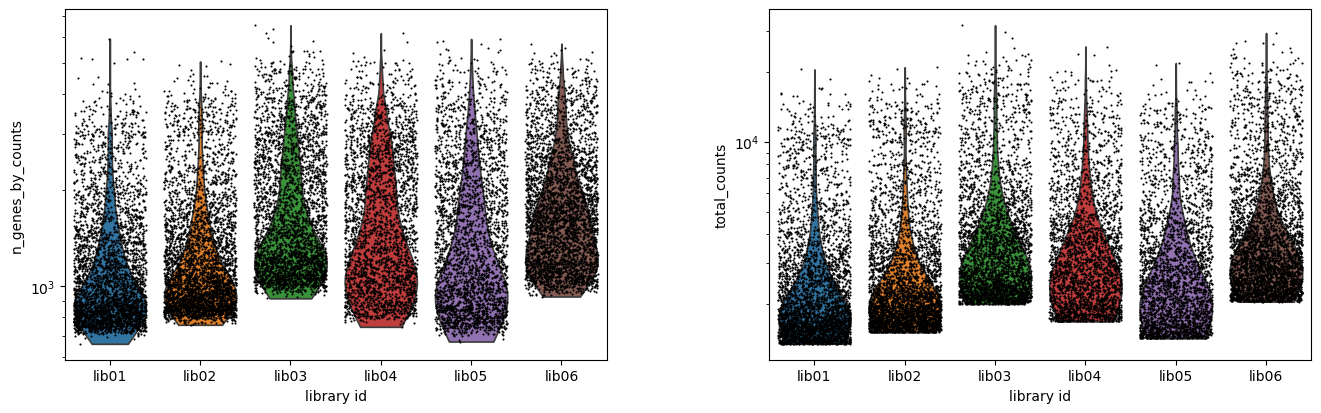

In [223]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], 
             groupby='library_id', size=1.5, log=True, jitter=0.4, multi_panel=True)

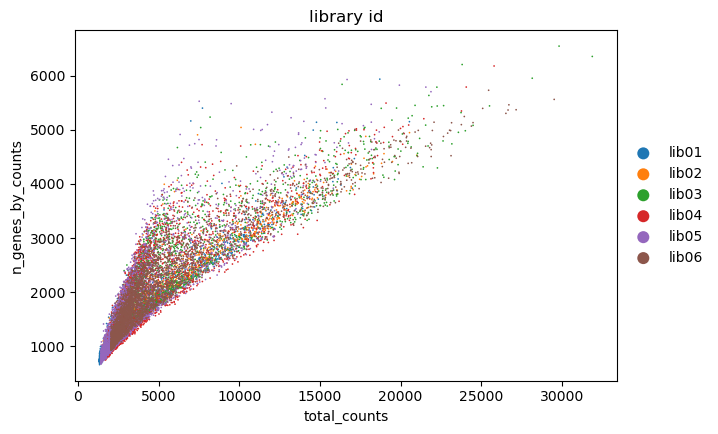

In [224]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='library_id')


In [225]:
summary = adata.obs.groupby("library_id")[["n_genes_by_counts", "total_counts"]].describe()
summary

/tmp/ipykernel_3491462/4100402543.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = adata.obs.groupby("library_id")[["n_genes_by_counts", "total_counts"]].describe()


n_genes_by_counts                                                   \
                       count         mean         std    min      25%     50%   
library_id                                                                      
lib01                 3531.0  1272.981592  673.693611  661.0   829.00  1008.0   
lib02                 3879.0  1370.642434  712.061708  758.0   903.00  1087.0   
lib03                 3312.0  1910.211353  973.873768  917.0  1162.75  1523.0   
lib04                 2736.0  1840.650950  948.152246  747.0  1059.00  1534.5   
lib05                 2871.0  1655.207593  962.115868  672.0   909.00  1304.0   
lib06                 3618.0  1915.809840  867.420605  929.0  1252.00  1661.0   

                            total_counts                                    \
                75%     max        count         mean          std     min   
library_id                                                                   
lib01       1442.00  5933.0       3531.0  2919.840088  2467.133545  1347.0   
lib02       1537.50  5041.0       3879.0  3234.073486  2778.736328  1510.0   
lib03       2405.00  6543.0       3312.0  4627.422363  3804.128174  2001.0   
lib04       2423.25  6176.0       2736.0  4243.335449  3289.107910  1682.0   
lib05       2127.00  5926.0       2871.0  3558.493652  2864.153076  1422.0   
lib06       2305.00  5728.0       3618.0  4680.362793  3796.848877  2047.0   

                                               
                25%     50%      75%      max  
library_id                                     
lib01       1560.00  1918.0  3030.00  20544.0  
lib02       1740.00  2126.0  3312.00  20999.0  
lib03       2360.00  3227.0  4961.75  31871.0  
lib04       2122.25  3038.0  4806.00  25788.0  
lib05       1748.00  2475.0  4090.00  21878.0  
lib06       2487.00  3261.0  4956.75  29511.0

Text(0.5, 1.0, 'Gene counts per cell')

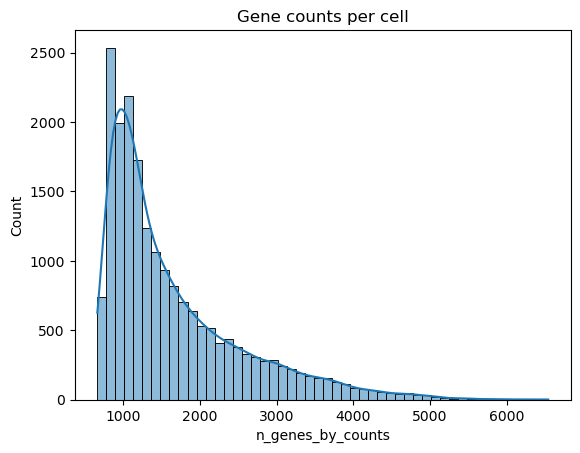

In [226]:
sns.histplot(data=adata.obs, x="n_genes_by_counts", bins=50, kde=True)
plt.title("Gene counts per cell")

Text(0.5, 1.0, 'Total counts per cell')

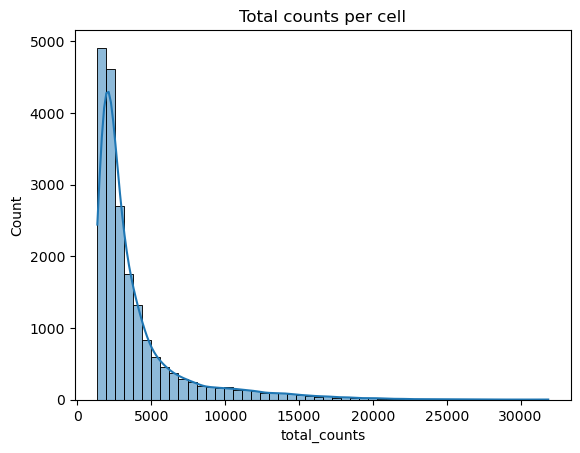

In [227]:
sns.histplot(data=adata.obs, x="total_counts", bins=50, kde=True)
plt.title("Total counts per cell")

## Preprocessing
pending: mt and ribo genes. Since they are not identified yet, we can not filter out damaged cells...
pending: use soup in R, reticulate python, in order to remove doublets in a better way

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
adata

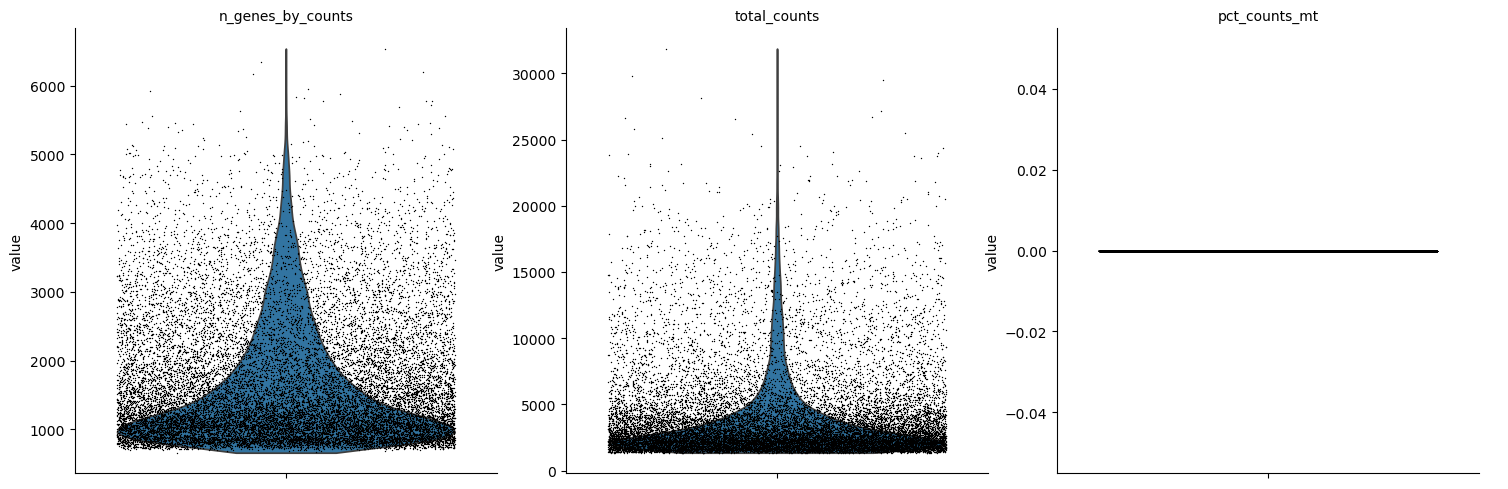

In [228]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Calculate QC metrics
adata.var["mt"] = adata.var_names.str.startswith("mito_")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
# Plot QC
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

## Filtering based on QC

In [229]:
# Apply thresholds based on inspection
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
# adata = adata[adata.obs.pct_counts_mt < 10, :] # mitocrondrial genes are not annotated in the var gene names
adata

View of AnnData object with n_obs × n_vars = 19943 × 37143
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'log_counts', 'log_genes', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'
    uns: 'library_id_colors'

## Add gene symbols to var_names with Matilde Paris equivalence table from transcripts to gene symbols
Using the files Tassos sent me from Averof lab, we can add gene symbols to the var_names of the AnnData object directly.
Pending: I will also try in paralel with the list John sent me with the gene symbols obtained from blasting to Uniprot.

Mathilde provided:
- Orthology table: Orthology_table_Phaw_Chiara2_vs_Hsap_Dmel.txt
- Contains mappings from Parhyale gene IDs to human (Hsap_name) and fly (Dmel_name) orthologs.

## Map gene IDs to symbols (human or Drosophila)

We map the Parhyale gene/transcript IDs to human-readable gene symbols using the orthology table provided by Mathilde.

- First, we try mapping to human gene names (`Hsap_name`).
- In future analysis we could consider mapping to Drosophila gene names (`Dmel_name`).
- If still unmatched, we retain the original transcript ID (`phaw`).

This produces a new column `gene_symbol` in `adata.var` for cleaner visualization and interpretation.

In [230]:
# this is how adata.var_names look like now
adata.var_names

Index(['mikado.phaw_50.283869dG450_AS', 'MSTRG.162', 'mikado.phaw_50.008432G2',
       'mikado.phaw_50.007301aG6', 'mikado.phaw_50.069823G2',
       'mikado.phaw_50.000135fG1490', 'mikado.phaw_50.001137bG654',
       'mikado.phaw_50.000135fG1492', 'mikado.phaw_50.000135fG1494',
       'mikado.phaw_50.001137bG650',
       ...
       'MSTRG.4005', 'MSTRG.4004', 'mikado.phaw_50.015400aG848',
       'mikado.phaw_50.015400aG848_AS', 'MSTRG.4009', 'MSTRG.39643',
       'mikado.phaw_50.011921G2', 'mikado.phaw_50.011921G2_AS',
       'mikado.phaw_50.033110G2', 'mikado.phaw_50.000214fG78'],
      dtype='object', length=37143)

In [231]:
#  Load orthology table and create lookup dictionaries
# This table links transcript IDs (from Parhyale) to their best human and Drosophila hits
ortho_df = pd.read_csv(
    "../../../workspace/scParhyale_data/Orthology_table_Phaw_Chiara2_vs_Hsap_Dmel.txt",
    sep="\t"
)

# Dictionaries for transcript-to-gene name mapping
phaw_to_hsap: dict = ortho_df.set_index("phaw")["Hsap_name"].dropna().to_dict()
phaw_to_dmel: dict = ortho_df.set_index("phaw")["Dmel_name"].dropna().to_dict()

#  Store the original transcript IDs before modifying var_names
adata.var["transcript_id"] = adata.var_names.copy()

# Map gene names using orthology table
# Priority: Human name > Dmel name > Original transcript ID [we can modify this later if needed]
def get_gene_symbol(phaw_id: str) -> str:
    return phaw_to_hsap.get(phaw_id) or phaw_to_dmel.get(phaw_id) or phaw_id

adata.var["gene_orth"] = [get_gene_symbol(gid) for gid in adata.var["transcript_id"]]

# Replace var_names with the mapped gene names (used throughout Scanpy)
adata.var_names = adata.var["gene_orth"]

# Categorize mapping source (human, dmel, unmapped)
def get_mapping_category(phaw_id: str) -> str:
    if phaw_id in phaw_to_hsap:
        return "human"
    elif phaw_id in phaw_to_dmel:
        return "dmel"
    else:
        return "unmapped"

adata.var["mapping_category"] = [get_mapping_category(gid) for gid in adata.var["transcript_id"]]

# Count transcripts in each mapping category
# --------------------------------------------------
mapping_counts = adata.var["mapping_category"].value_counts().rename("Transcript count").to_frame()

# display results of the mapping
mapping_counts

/tmp/ipykernel_3491462/2052977446.py:13: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["transcript_id"] = adata.var_names.copy()


Transcript count
mapping_category                  
human                        30489
unmapped                      6654

multiple rows (transcripts) correspond to the same gene symbol orthology-mapped, we will sum their expression counts across all cells. This is the standard approach in cases of transcript-to-gene or transcript-to-homology mapping.

In [232]:
# some transcript ID were mapped to the same human gene, we want to aggregate the counts from those transcripts
adata.var_names.value_counts()

gene_orth
-                                329
FBXL7                             80
REST                              77
ZNF160                            63
TTN                               62
                                ... 
ALOXE3                             1
mikado.phaw_50.283829bG258_AS      1
CYP8B1                             1
SLC45A3                            1
mikado.phaw_50.019070G14_AS        1
Name: count, Length: 19528, dtype: int64

In [234]:
# Step 1: Convert to dense DataFrame (uses var_names as columns)
expression_df = adata.to_df()

# Step 2: Aggregate expression values by duplicated gene names
aggregated_df = expression_df.T.groupby(level=0).sum().T

# Step 3: Create new AnnData with same obs
adata_aggregated = anndata.AnnData(
    X=scipy.sparse.csr_matrix(aggregated_df.values),
    obs=adata.obs.copy(),
    var=pd.DataFrame(index=aggregated_df.columns)
)

# (Optional) Recalculate QC, normalize again, etc.
print(f"Aggregated shape: {adata_aggregated.shape}")

Aggregated shape: (19943, 19528)


In [238]:
adata = adata_aggregated

19528 genes remaining

## Normalization and Log Transformation

In [239]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()  # Store a safe, immutable version of the normalized + log-transformed data

## Highly Variable Genes

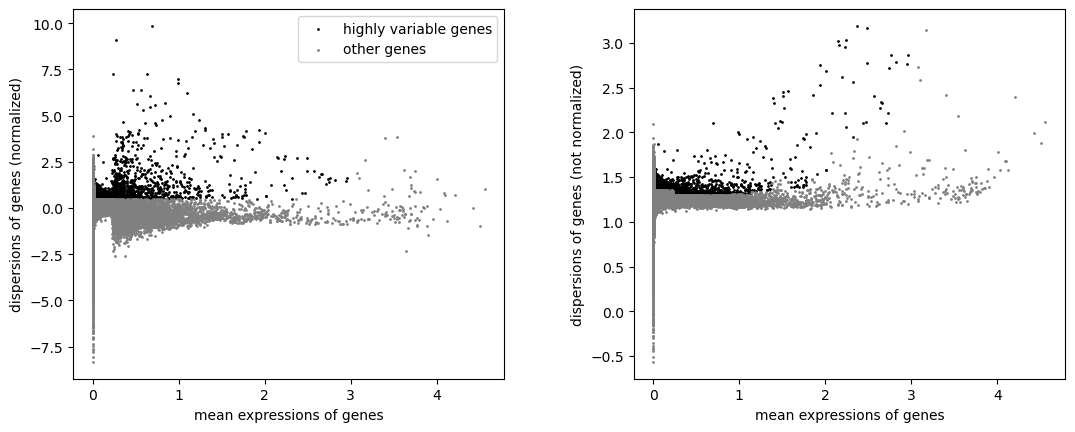

In [240]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable].copy() 

## PCA, Neighbors, UMAP
Initially we start without batch correction (data integration between batches)

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


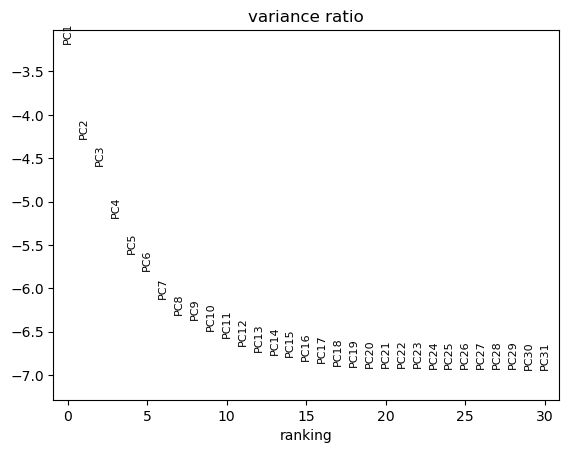

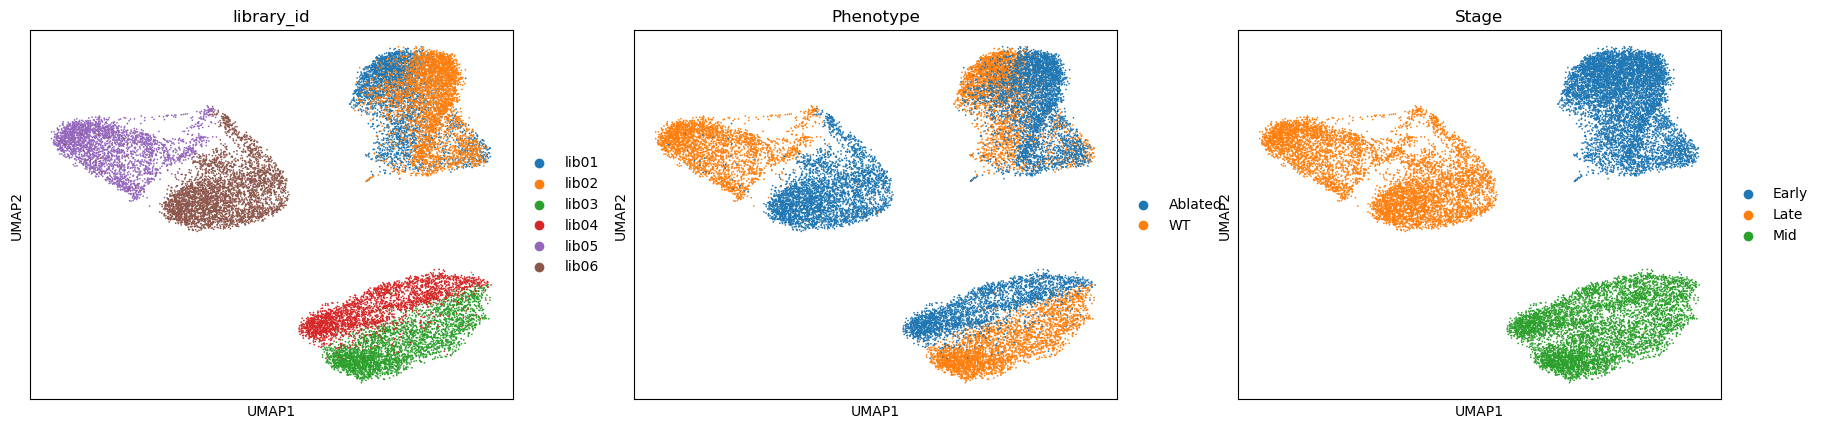

In [241]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['library_id', 'Phenotype', 'Stage'])

## Data integration (batch correction)
Following best practices in scRNAseq
https://www.sc-best-practices.org/cellular_structure/integration.html

Data integration methods work in these steps:
1. Dimensionality reduction.
2. Modeling and removing the batch effect.
3. Projection back into a high-dimensional space.


Batch-effect removal methods can vary in each of these three steps. They may use various linear or non-linear dimensionality reduction approaches, linear or non-linear batch effect models, and they may output different formats of batch-corrected data. Overall, we can divide methods for batch effect removal into 4 categories. In their order of development, these are global models, linear embedding models, graph-based methods, and deep learning approaches.

We will try this three libraries: Harmony, bbknn and scVI.


### Graph-based method: BBKNN (Batch Balanced KNN)
Graph-based method

⚠️ BBKNN modifies the neighborhood graph — do not re-run sc.pp.neighbors() after it.

In [242]:
import scanpy.external as sce

sce.pp.bbknn(adata, batch_key='library_id')
sc.tl.umap(adata)

consider updating your call to make use of `computation`


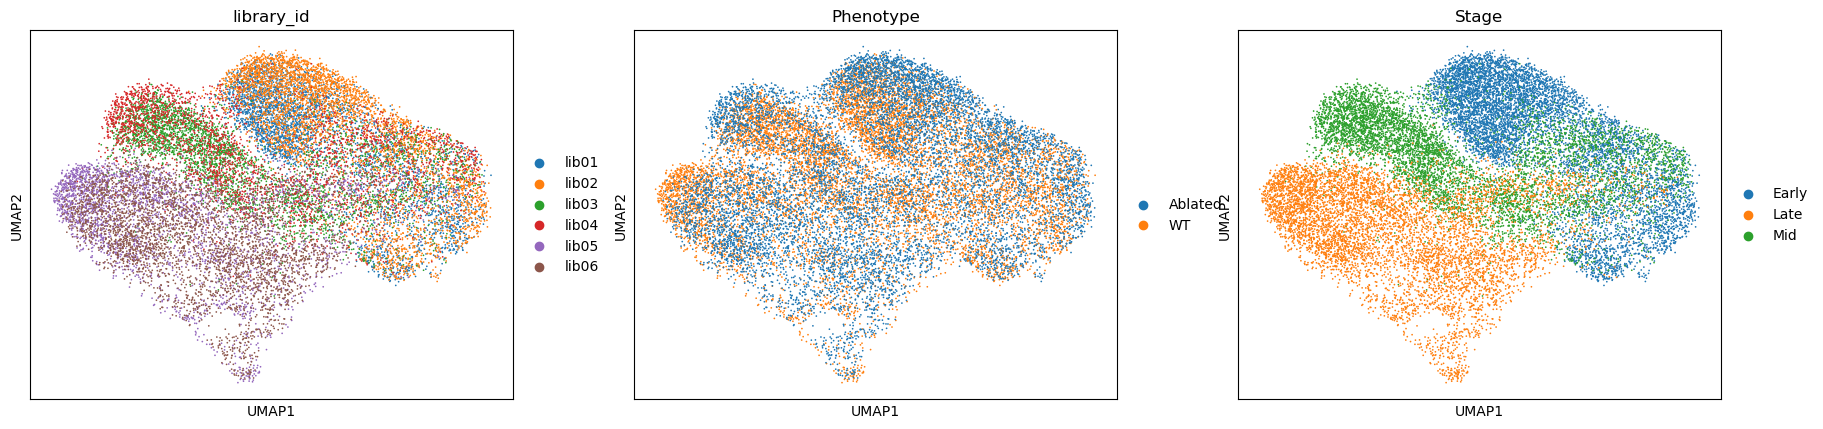

In [243]:
sc.pl.umap(adata, color=["library_id", "Phenotype", "Stage"])

In [245]:
# Save the AnnData object with BBKNN neighbors before applying other batch correction methods
adata_bbknn = adata.copy()
adata_bbknn.write(PROC_DATA_DIR / "adata_bbknn_newmapping.h5ad")

### Deep learning method: scVI (Single-cell Variational Inference)
Pending: currently I am on the CPU workstation and I don't want to switch

## Clustering

### Option 1 From cluster differentially expressed genes to cluster annotation

In [ ]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res1_5", resolution=1.5)


In [266]:
adata

AnnData object with n_obs × n_vars = 19943 × 1766
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'log_counts', 'log_genes', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_res1_5'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'library_id_colors', 'Phenotype_colors', 'Stage_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'leiden_res1_5'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

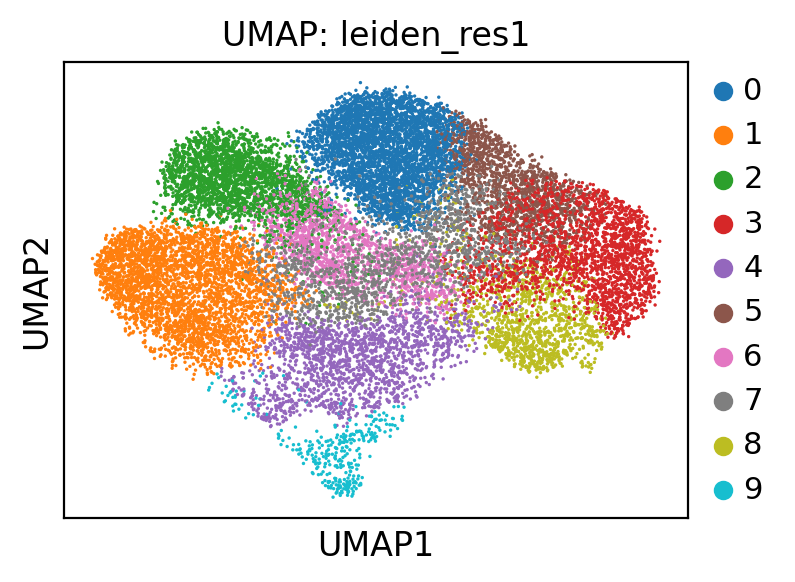

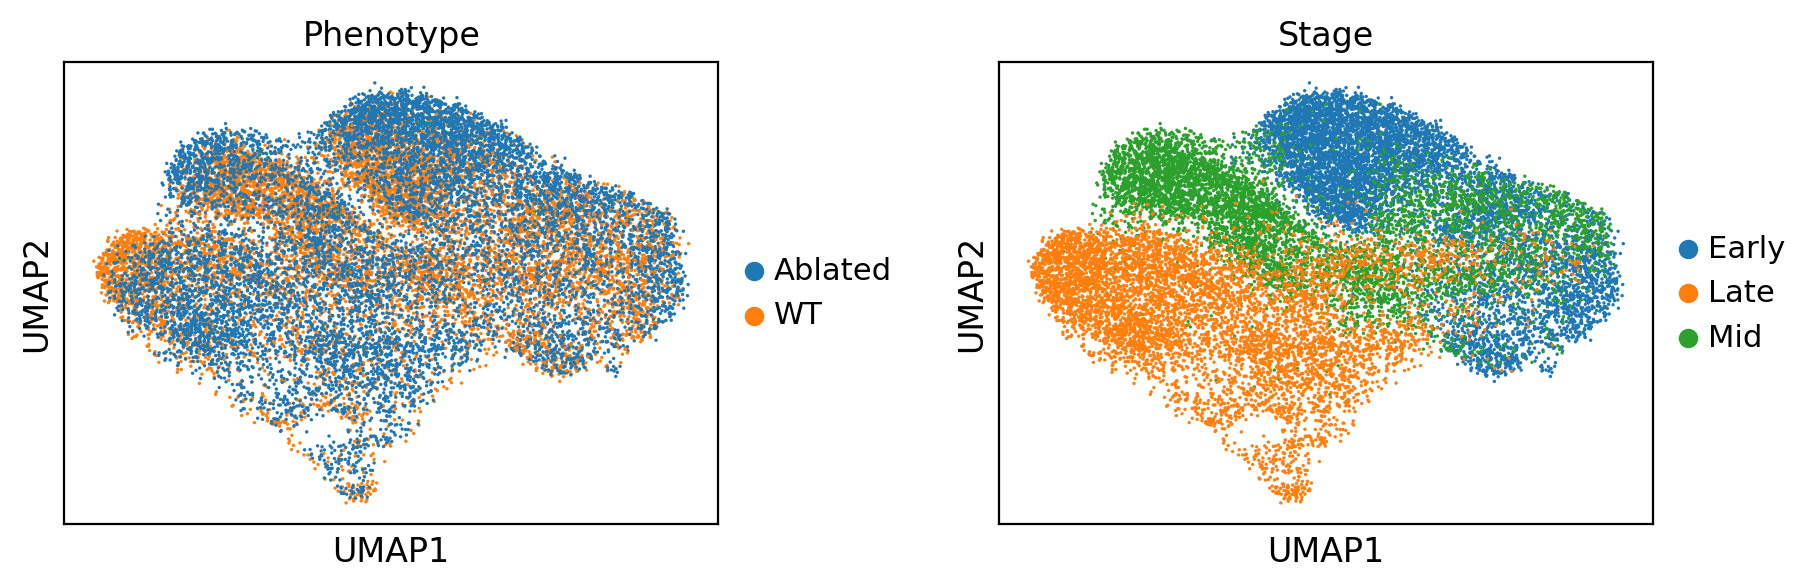

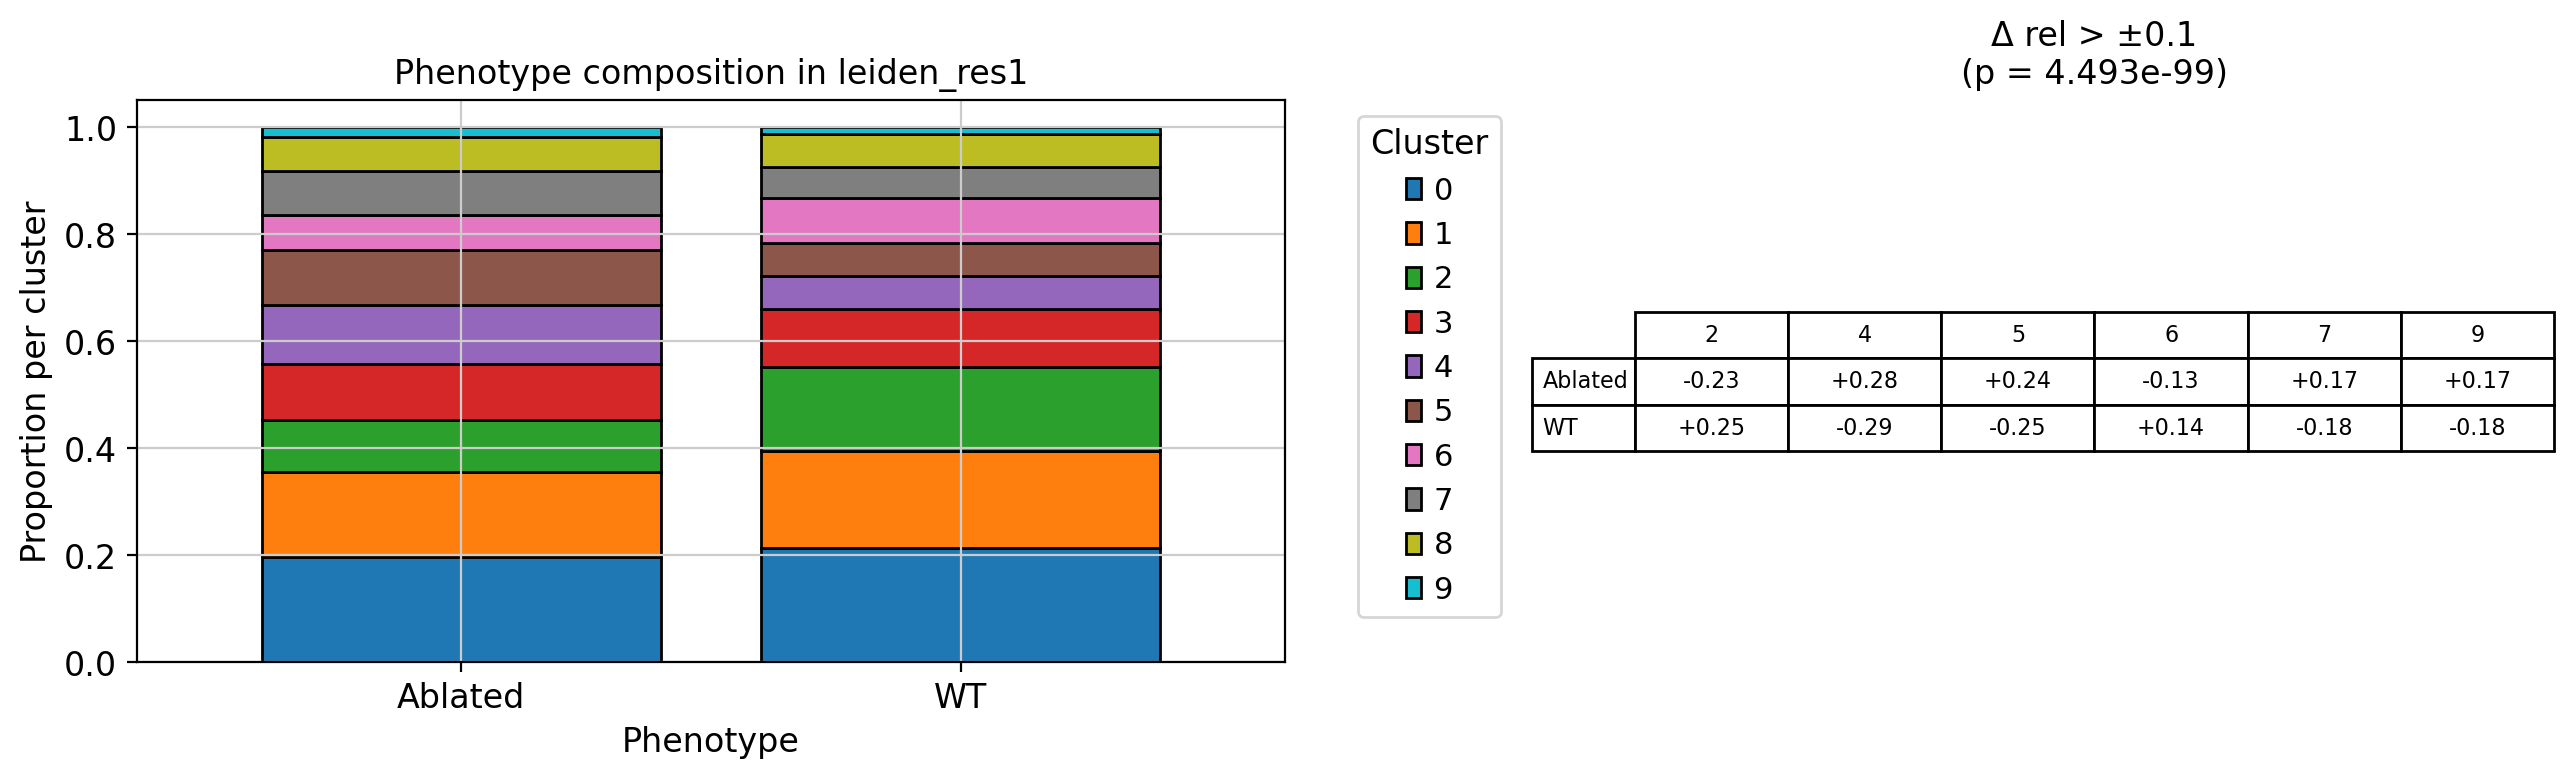

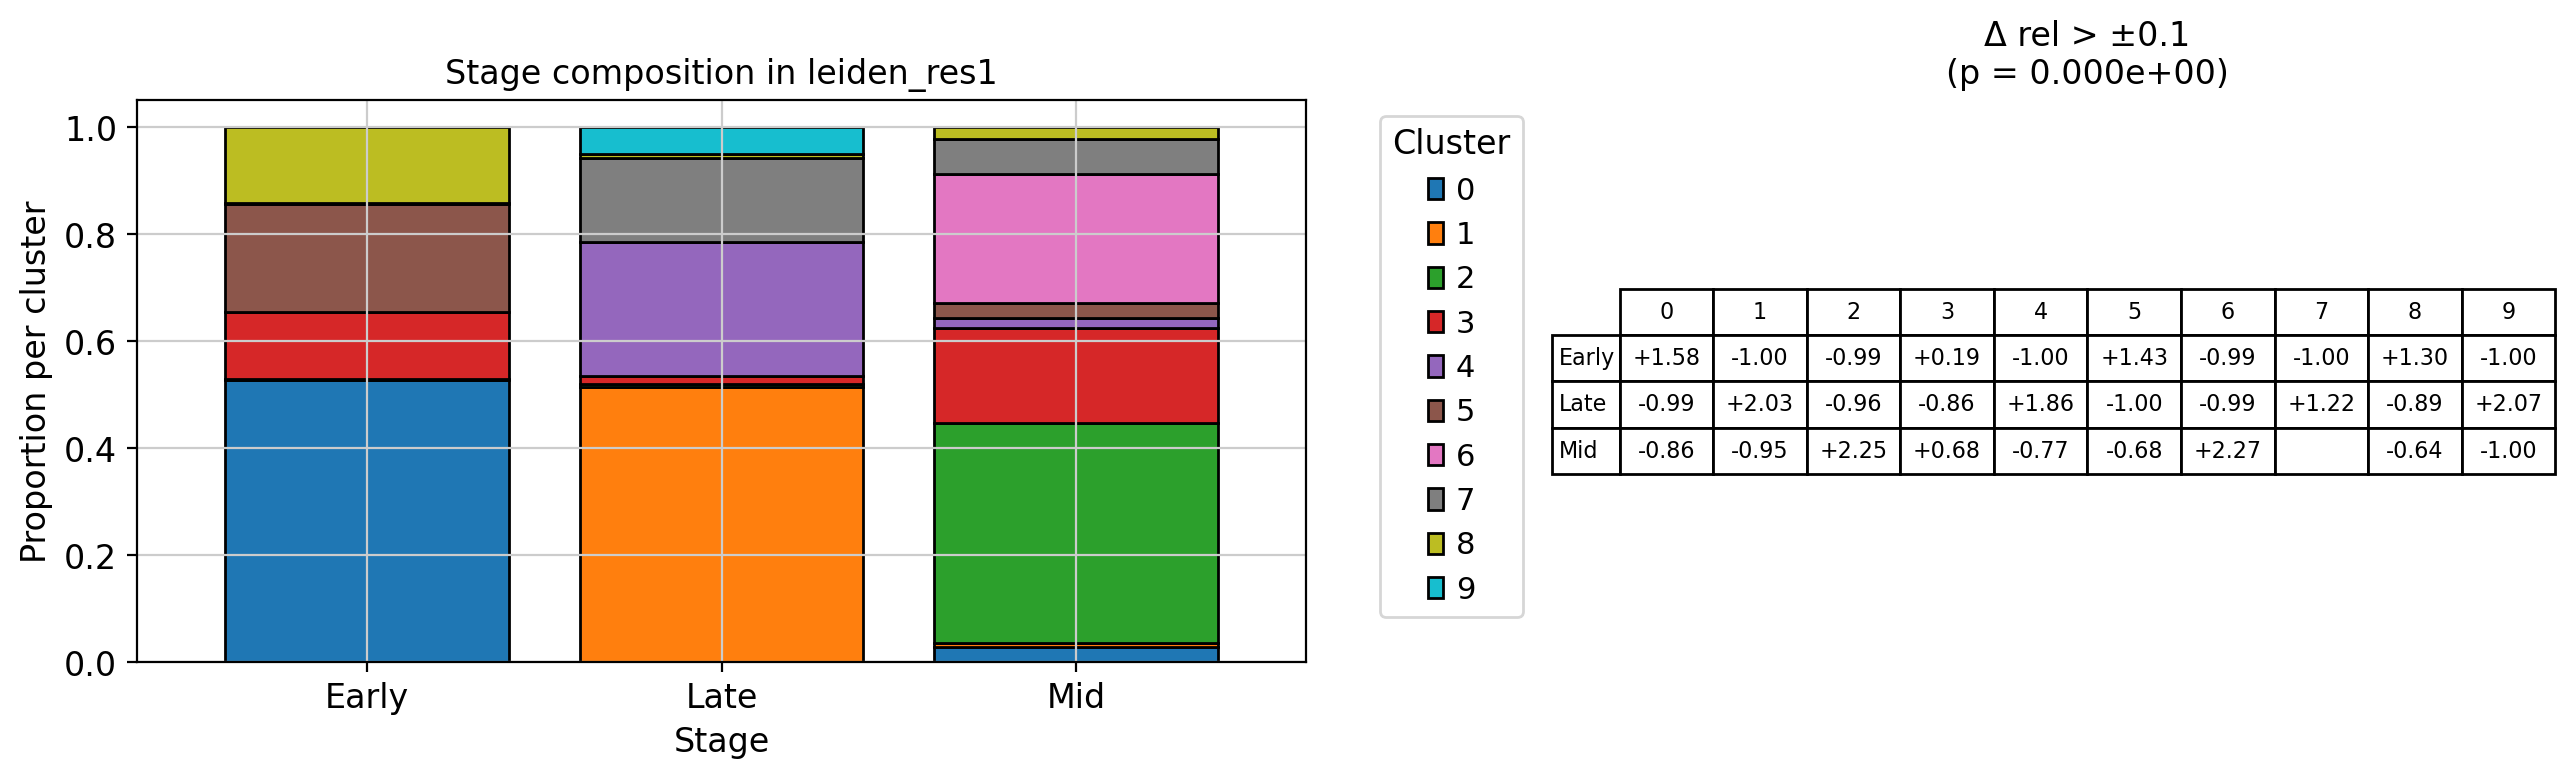

Cluster   Metadata Category Deviation    Status
12       0      Stage    Early     +1.58  Enriched
22       0      Stage     Late     -0.99  Depleted
32       0      Stage      Mid     -0.86  Depleted
13       1      Stage    Early     -1.00  Depleted
23       1      Stage     Late     +2.03  Enriched
33       1      Stage      Mid     -0.95  Depleted
0        2  Phenotype  Ablated     -0.23  Depleted
6        2  Phenotype       WT     +0.25  Enriched
14       2      Stage    Early     -0.99  Depleted
24       2      Stage     Late     -0.96  Depleted
34       2      Stage      Mid     +2.25  Enriched
15       3      Stage    Early     +0.19  Enriched
25       3      Stage     Late     -0.86  Depleted
35       3      Stage      Mid     +0.68  Enriched
1        4  Phenotype  Ablated     +0.28  Enriched
7        4  Phenotype       WT     -0.29  Depleted
16       4      Stage    Early     -1.00  Depleted
26       4      Stage     Late     +1.86  Enriched
36       4      Stage      Mid     -0.77  Depleted
2        5  Phenotype  Ablated     +0.24  Enriched
8        5  Phenotype       WT     -0.25  Depleted
17       5      Stage    Early     +1.43  Enriched
27       5      Stage     Late     -1.00  Depleted
37       5      Stage      Mid     -0.68  Depleted
3        6  Phenotype  Ablated     -0.13  Depleted
9        6  Phenotype       WT     +0.14  Enriched
18       6      Stage    Early     -0.99  Depleted
28       6      Stage     Late     -0.99  Depleted
38       6      Stage      Mid     +2.27  Enriched
4        7  Phenotype  Ablated     +0.17  Enriched
10       7  Phenotype       WT     -0.18  Depleted
19       7      Stage    Early     -1.00  Depleted
29       7      Stage     Late     +1.22  Enriched
20       8      Stage    Early     +1.30  Enriched
30       8      Stage     Late     -0.89  Depleted
39       8      Stage      Mid     -0.64  Depleted
5        9  Phenotype  Ablated     +0.17  Enriched
11       9  Phenotype       WT     -0.18  Depleted
21       9      Stage    Early     -1.00  Depleted
31       9      Stage     Late     +2.07  Enriched
40       9      Stage      Mid     -1.00  Depleted

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scanpy as sc

leiden_col = "leiden_res1"
meta_categories = ["Phenotype", "Stage"]

def composition_test(adata, cluster_col, meta_col):
    contingency = pd.crosstab(adata.obs[meta_col], adata.obs[cluster_col])
    chi2, p, dof, expected = chi2_contingency(contingency)
    expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
    return p, contingency, expected_df

# Plot UMAPs
sc.pl.umap(adata, color=leiden_col, title=f"UMAP: {leiden_col}", show=False)
sc.pl.umap(adata, color=meta_categories, wspace=0.3, show=False)

# For storing cluster summaries
summary_records = []

for meta in meta_categories:
    pval, obs, exp = composition_test(adata, leiden_col, meta)
    rel_diff = (obs - exp) / exp
    threshold = 0.1
    hits = rel_diff.abs() > threshold

    summary_data = []
    for category in rel_diff.index:
        for cluster in rel_diff.columns:
            deviation = rel_diff.loc[category, cluster]
            if hits.loc[category, cluster]:
                status = "Enriched" if deviation > 0 else "Depleted"
                summary_data.append([cluster, category, f"{deviation:+.2f}", status])
                # Store for final summary table
                summary_records.append({
                    "Cluster": cluster,
                    "Category": category,
                    "Metadata": meta,
                    "Deviation": f"{deviation:+.2f}",
                    "Status": status
                })

    summary_df = pd.DataFrame(summary_data, columns=["Cluster", meta, "Δ rel", "Status"])

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), gridspec_kw={"width_ratios": [1.5, 1]})

    prop_df = (obs.T / obs.T.sum()).T
    prop_df.plot(
        kind="bar", stacked=True, colormap="tab10", edgecolor="black",
        ax=axes[0], width=0.8
    )
    axes[0].set_title(f"{meta} composition in {leiden_col}")
    axes[0].set_xlabel(meta)
    axes[0].set_ylabel("Proportion per cluster")
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    axes[1].axis("off")
    if not summary_df.empty:
        table_data = summary_df.pivot(index=meta, columns="Cluster", values="Δ rel").fillna("")
        table = axes[1].table(
            cellText=table_data.values,
            rowLabels=table_data.index,
            colLabels=table_data.columns,
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 1.5)
        axes[1].set_title(f"Δ rel > ±{threshold}\n(p = {pval:.3e})")
    else:
        axes[1].text(0.5, 0.5, "No significant deviations", ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Final summary as a DataFrame
summary_table = pd.DataFrame(summary_records)
summary_table = summary_table[["Cluster", "Metadata", "Category", "Deviation", "Status"]]
summary_table.sort_values(["Cluster", "Metadata"], inplace=True)

# Show as table
import IPython.display as display
display.display(summary_table)

# Optional: save to file
# summary_table.to_csv("cluster_composition_summary.csv", index=False)

## Marker Gene Identification

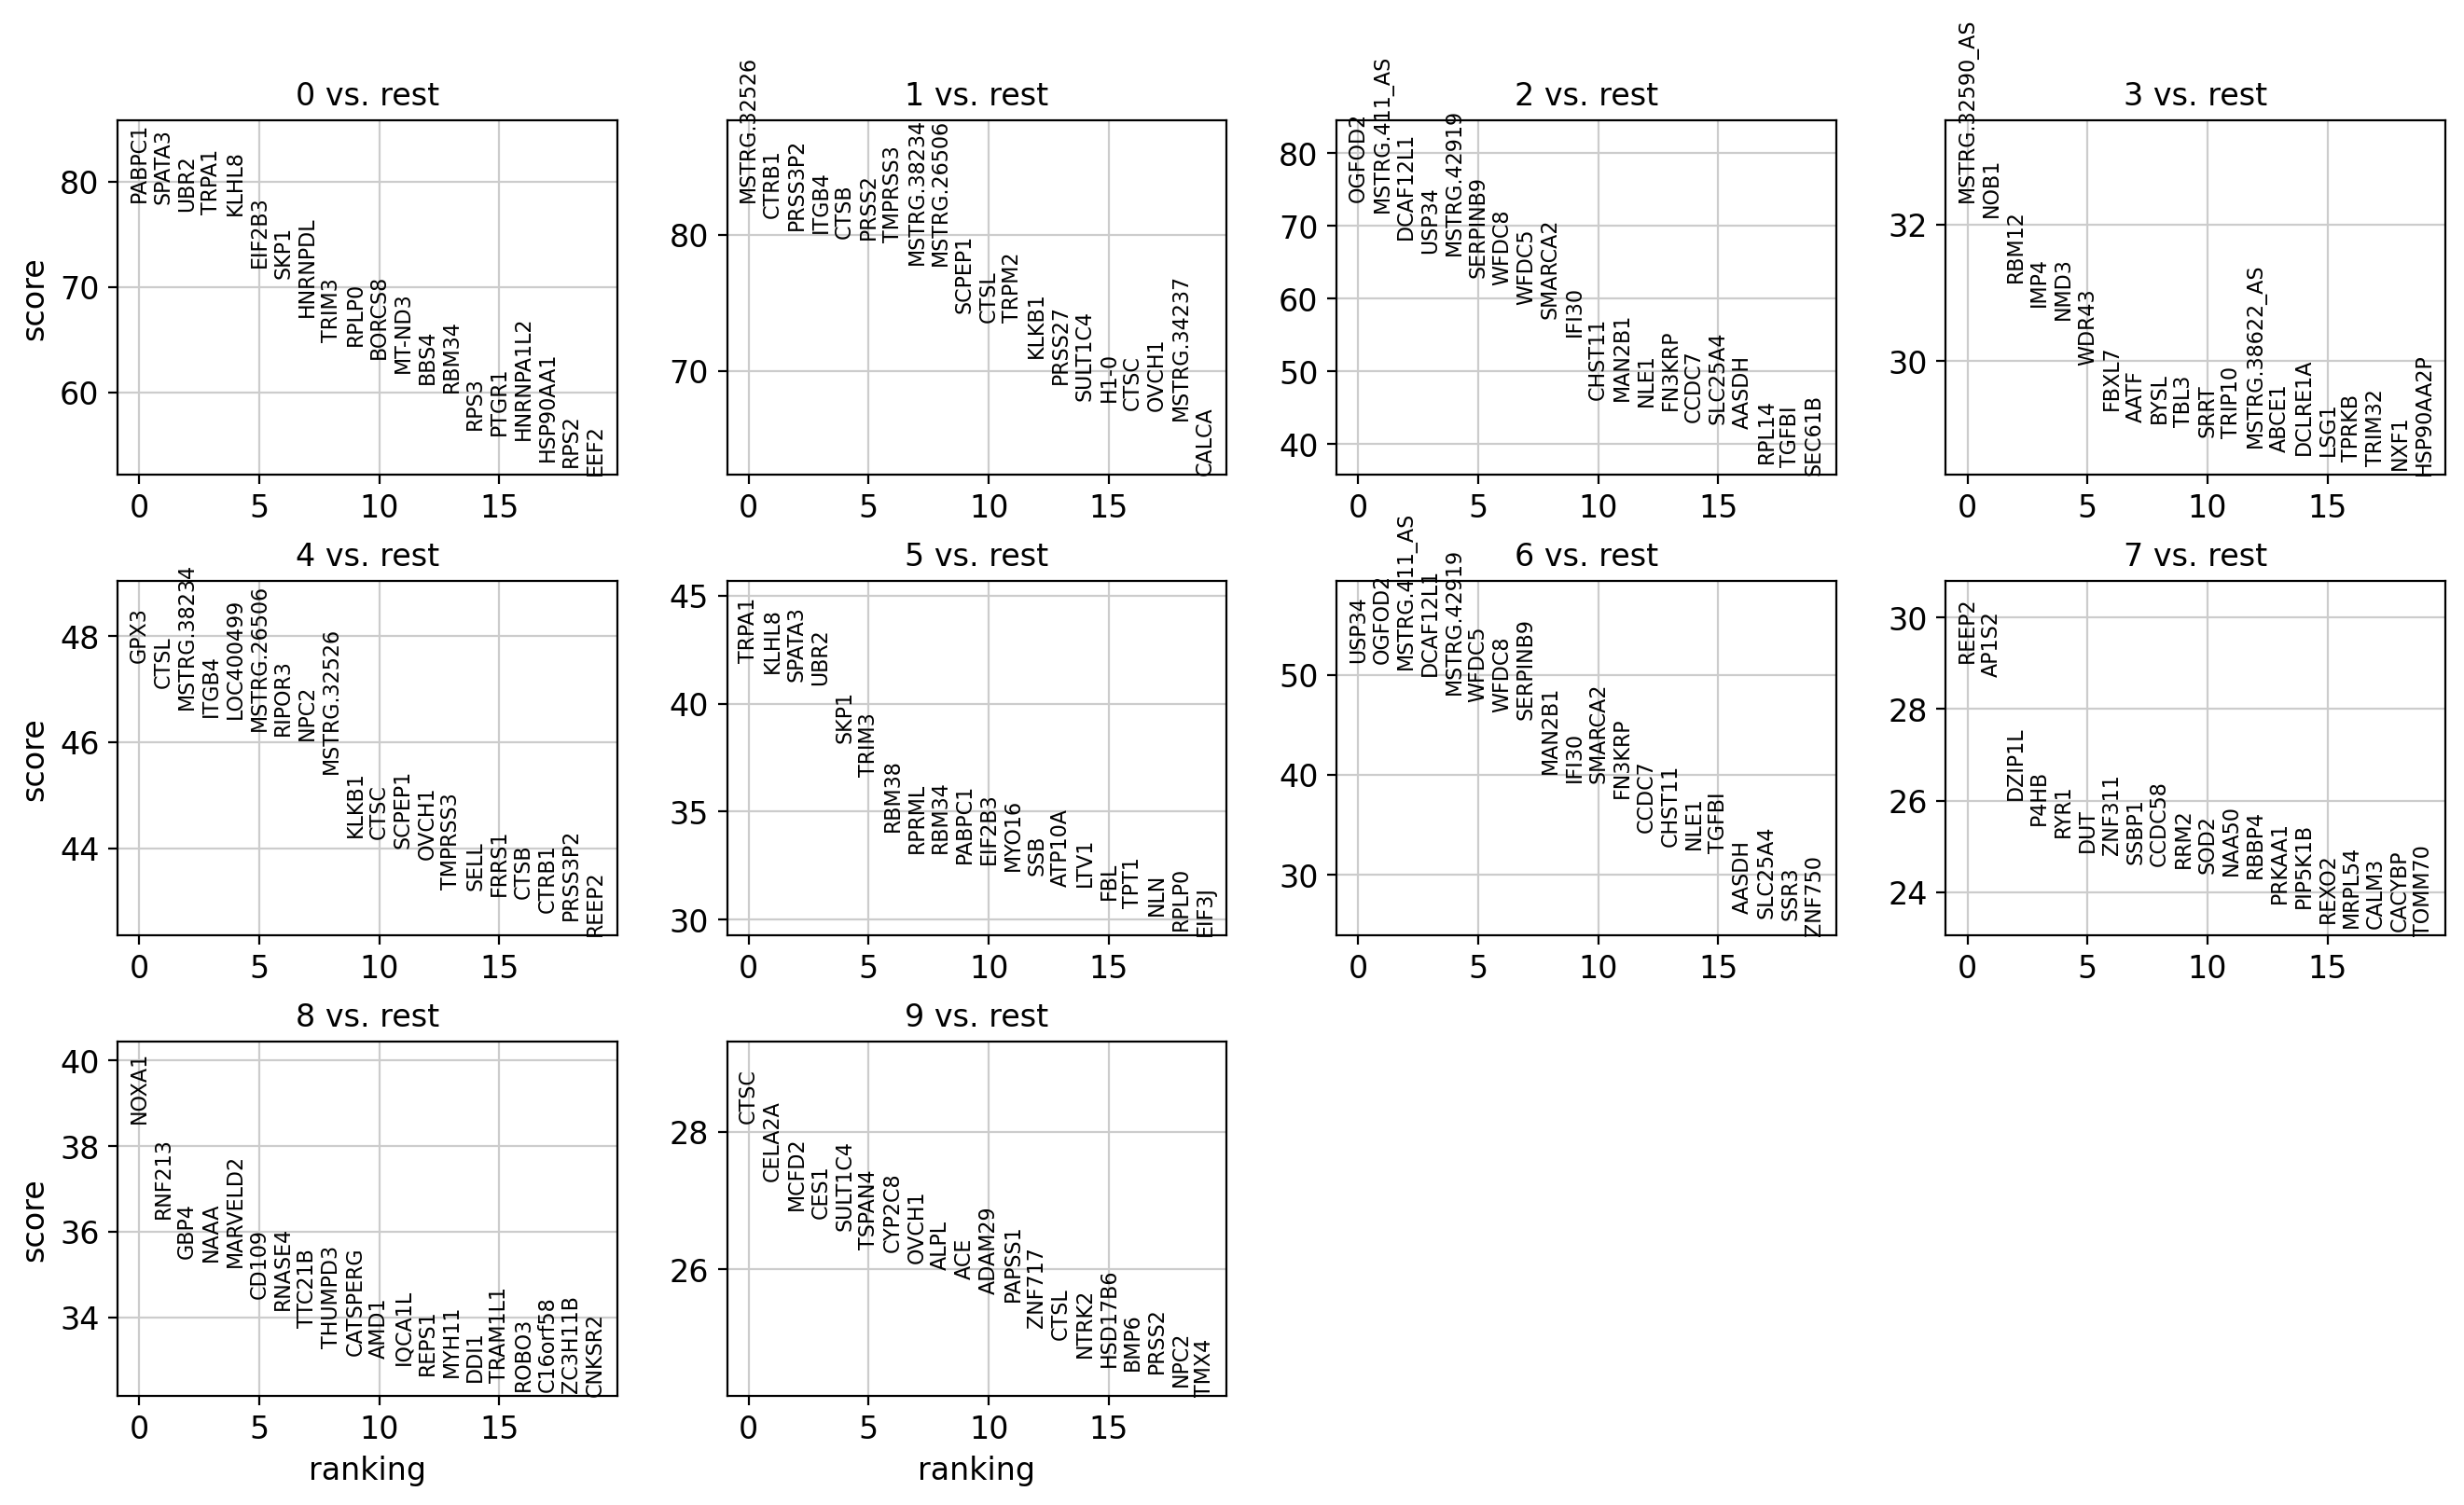

In [309]:
# Run marker gene detection using the full expression matrix (stored in adata.raw) not only the highly variable genes
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_res1",
    method="wilcoxon",
    key_added="leiden_res1_wilcoxon",
    use_raw=True
)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [311]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="leiden_res1_wilcoxon",
    key_added="leiden_res1_filtered",
)

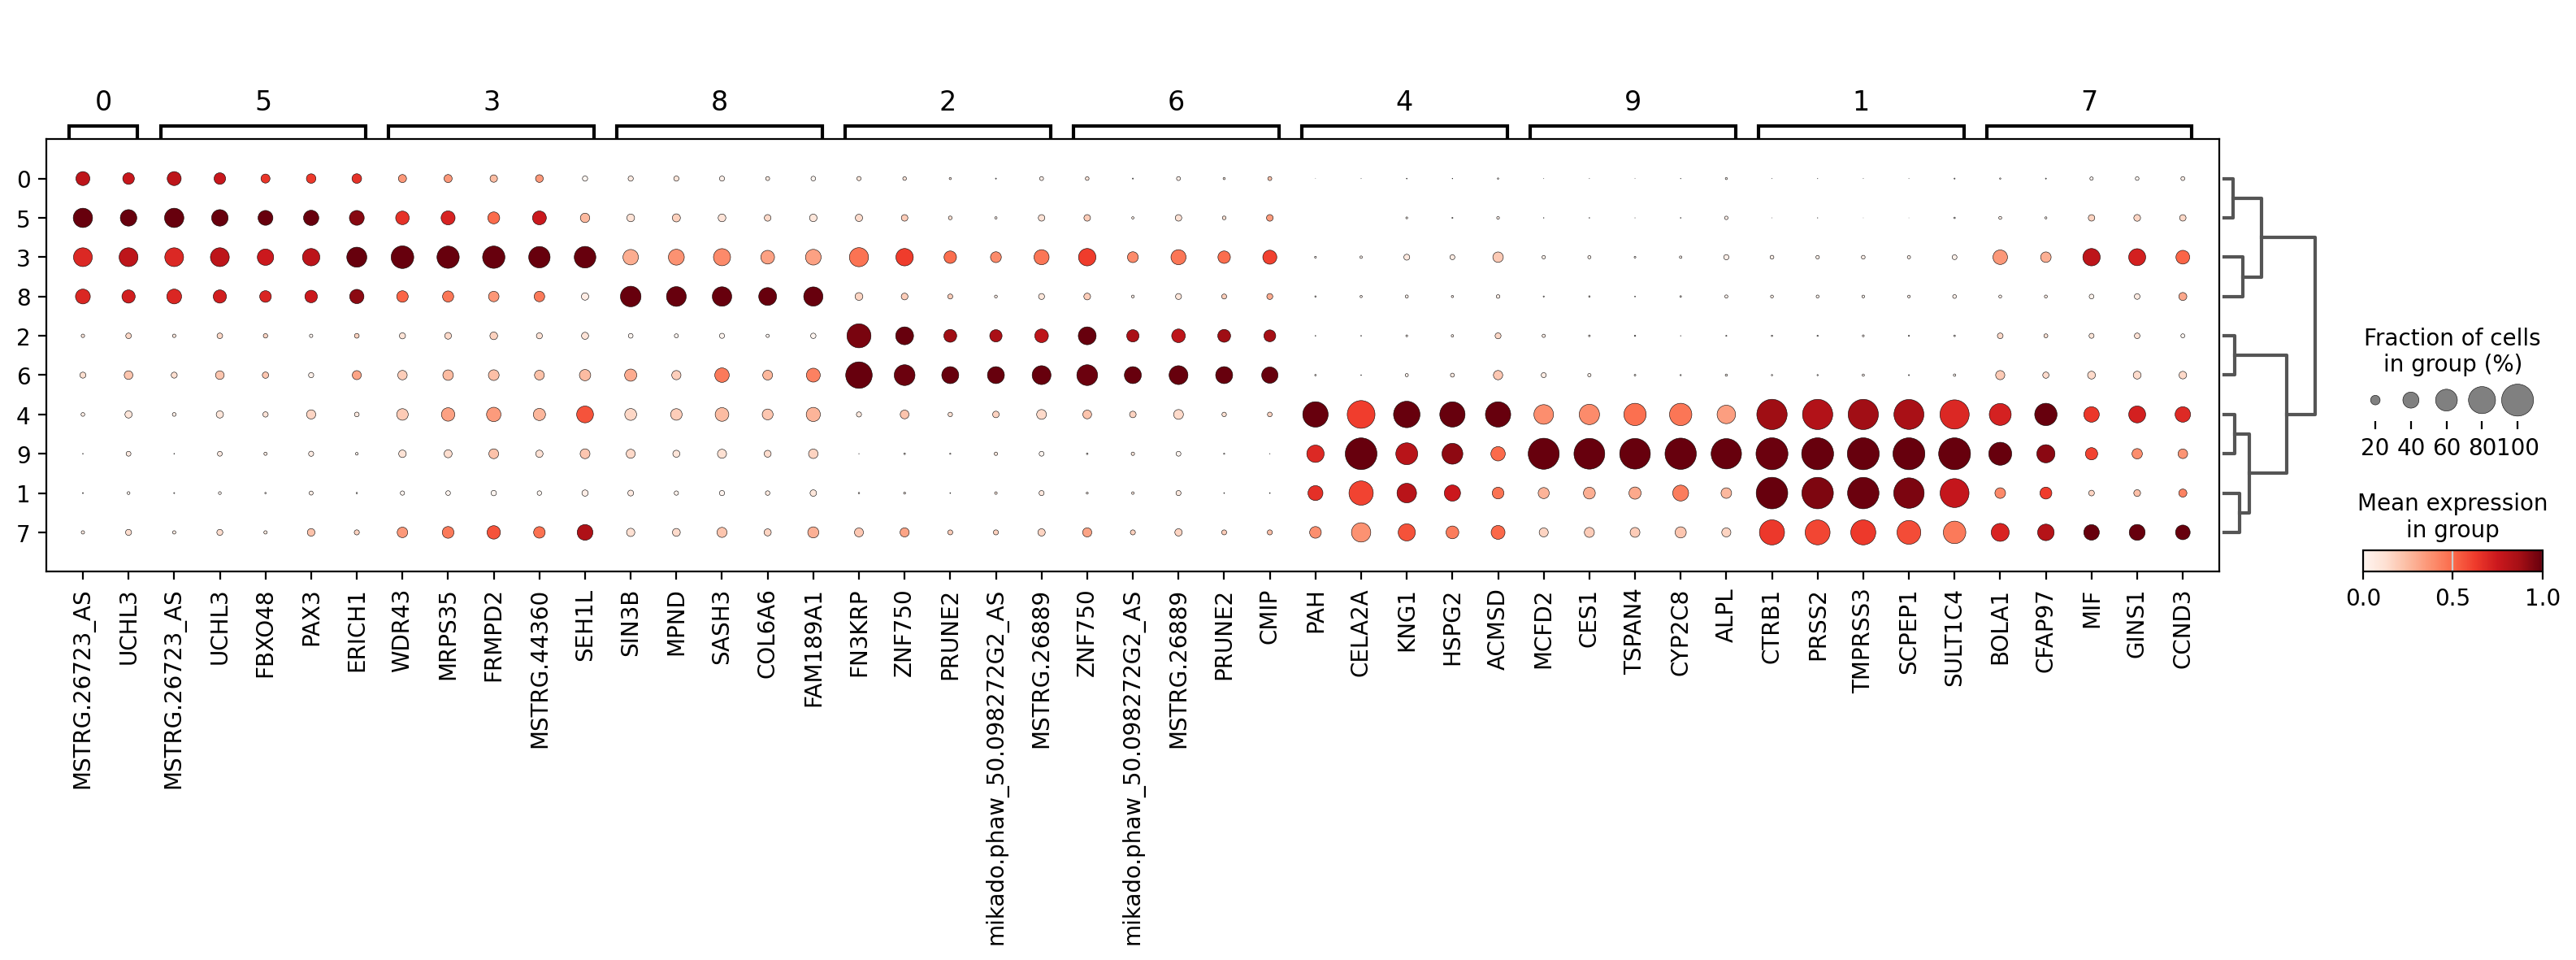

In [314]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=5,
    groupby='leiden_res1',          # this must be an actual column in `adata.obs`
    key='leiden_res1_filtered',     # this selects the filtered gene list
    dendrogram=True,
    standard_scale='var',
    swap_axes=False,
    show=True
)

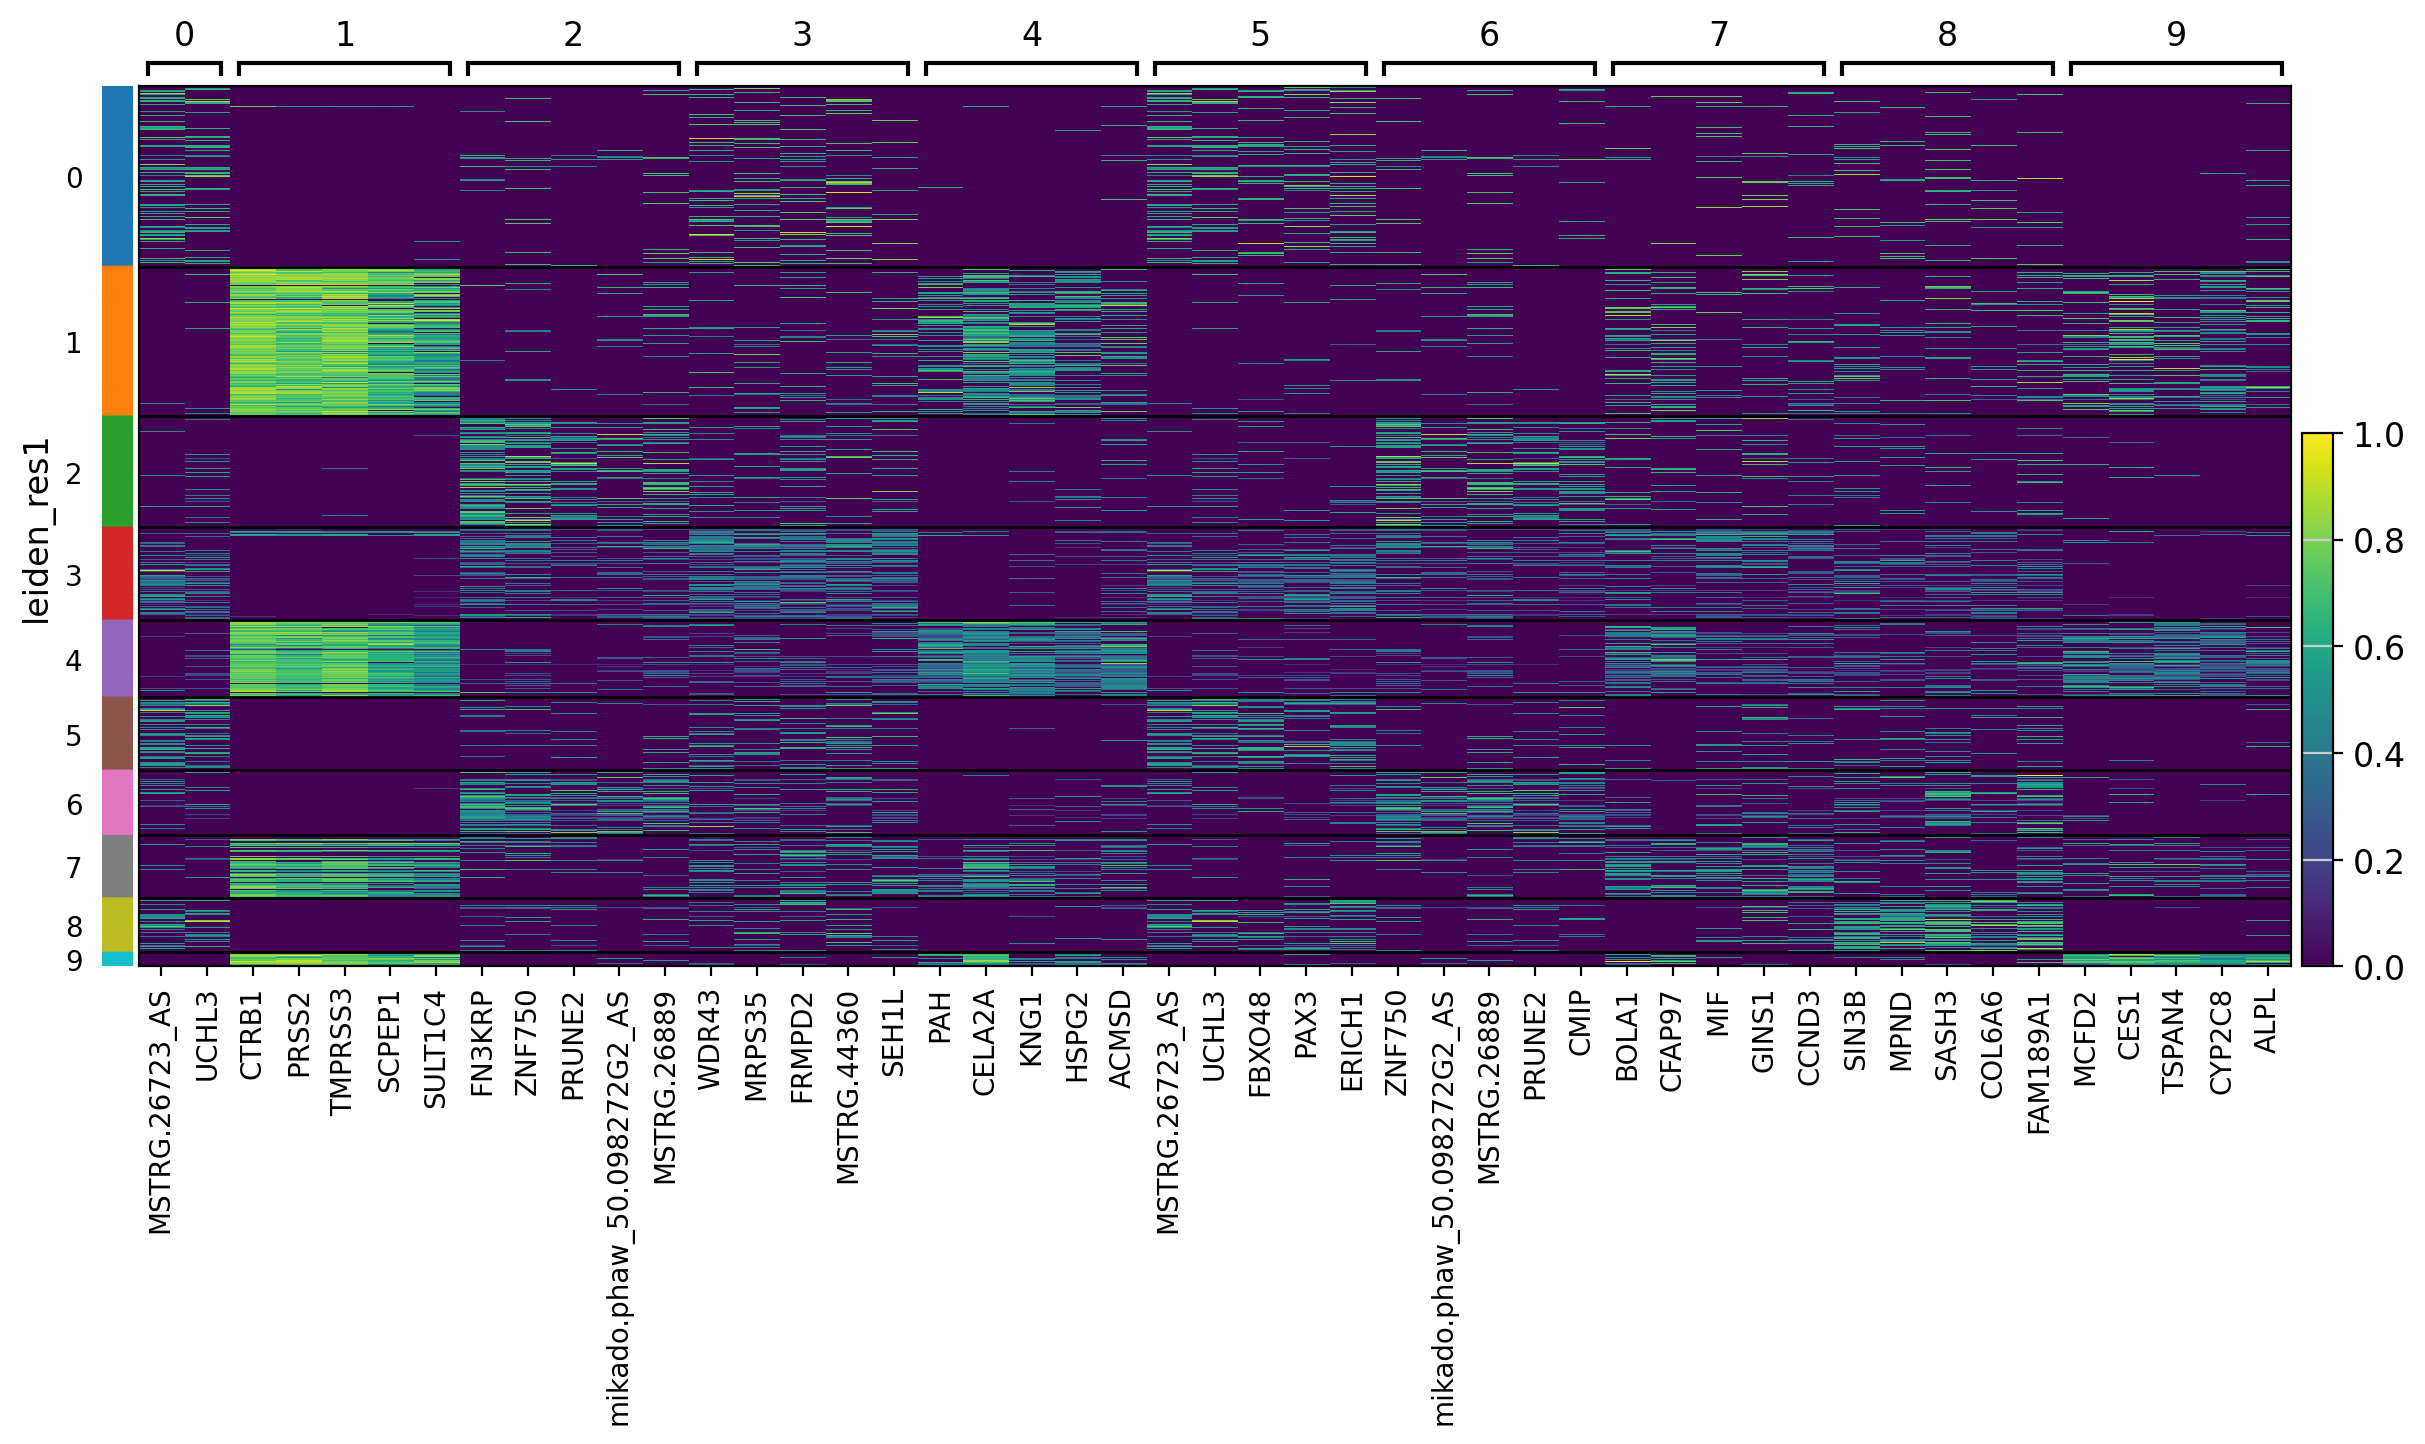

In [315]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby='leiden_res1',         
    key='leiden_res1_filtered',  
    show=True,
    cmap="viridis",
    standard_scale='var',
    use_raw=True,  # assumes log1p normalized data in `.X`
    dendrogram=False
)

### Option 2 From Tassos markers to cluster annotation
Pending